REQUIRED PACKAGES

In [114]:
# installation of required packages
!pip3 install pandas
!pip3 install numpy
!pip install pandas pyarrow
!pip install matplotlib
!pip install scipy
!pip install prophet
!pip install seaborn
!pip install scikit-learn
!pip install skl2onnx
!pip install onnxruntime
!pip install pydot
!pip install graphviz


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



In [115]:
import sys
sys.path.append("/Users/waseempashamohammad/DPA-project/env/lib/python3.13/site-packages")

### Importing all the required Libraries

In [116]:
import pandas as pd
import pyarrow as pa
import pyarrow.orc as orc
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split


In [117]:
# supressing warning
import warnings
warnings.filterwarnings("ignore")

### Importing Data to Dataframe

In [118]:

df = pd.read_csv("data_public.csv")
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,3
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,2
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,3
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


In [119]:
print(df['Class'].unique())
# distinct classes

[3 2 1]


### This code reads the CSV file into a pandas DataFrame, converts the DataFrame to a PyArrow Table, and then writes the Table to an ORC file.

ORC is a columnar storage file format that is optimized for read-heavy operations and is commonly used in the distributed ecosystem.

In [120]:
table = pa.Table.from_pandas(df)

with pa.OSFile('data_public.orc', 'wb') as sink:
    orc.write_table(table, sink)

In [121]:
%%time
df = pd.read_orc('data_public.orc')

CPU times: user 59.2 ms, sys: 78.1 ms, total: 137 ms
Wall time: 73.3 ms


In [122]:
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,3
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,2
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,3
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


### To Remove outliers from the dataset, we are using Empirical Rule (68-95-99.7 Rule)
By setting the threshold to 3, you are identifying data points that lie beyond 3 standard deviations from the mean. These points are in the extreme 0.3% of the data, making them highly unusual or rare.

In [123]:
plt.figure(figsize=(10, 6))

# Function to plot a single column
def plot_single_column(df, column):
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[column])
    plt.title(f'Scatter Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()

# Function to remove outliers based on Z-score
def remove_outliers(df, column, threshold=3):
    z_scores = stats.zscore(df[column])
    abs_z_scores = abs(z_scores)
    filtered_entries = (abs_z_scores < threshold)
    return df[filtered_entries]


<Figure size 1000x600 with 0 Axes>

In [124]:

# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'A')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1200000
1200000


In [125]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'B')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1200000
1194082


In [126]:

# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'C')

print(df.shape[0])
print(df_no_outliers.shape[0])



df=df_no_outliers

1194082
1194082


In [127]:

# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'D')

print(df.shape[0])
print(df_no_outliers.shape[0])


df=df_no_outliers

1194082
1194082


In [128]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'E')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1194082
1194082


In [129]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'F')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1194082
1194082


In [130]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'G')

print(df.shape[0])
print(df_no_outliers.shape[0])


df=df_no_outliers

1194082
1194082


In [131]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'H')

print(df.shape[0])
print(df_no_outliers.shape[0])


df=df_no_outliers

1194082
1194082


In [281]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'I')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1193568
1193568


In [133]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'J')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1194082
1194082


In [134]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'K')

print(df.shape[0])
print(df_no_outliers.shape[0])


df=df_no_outliers

1194082
1194082


In [135]:


# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'L')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1194082
1193568


In [136]:


# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'M')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1193568
1193568


In [137]:


# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'N')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1193568
1193568


In [138]:
# Remove outliers from column 'A'
df_no_outliers = remove_outliers(df, 'O')

print(df.shape[0])
print(df_no_outliers.shape[0])

df=df_no_outliers

1193568
1193568


## STEP 2: DATA ANALYSIS


In [139]:
df.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06,1.193568e+06
mean,5.128392e+01,-1.859263e+01,7.222868e+01,-1.301710e+01,2.967942e+01,-5.541849e+00,3.219800e+01,5.144430e+01,3.289575e+01,4.165047e+01,7.956147e+01,-6.566544e+00,-4.226541e+01,4.957139e+01,5.980250e+01,2.325884e+00
std,1.293398e+02,1.411861e+01,1.052374e+02,4.645263e+01,7.294606e+01,7.275798e+01,6.649090e+01,1.035912e+02,4.225891e+01,7.651200e+01,9.506301e+01,1.541496e+01,1.793686e+01,6.745263e+01,6.695608e+01,7.189405e-01
min,-7.308940e+01,-6.222383e+01,-5.972853e+01,-1.375818e+02,-3.829826e+01,-1.485917e+02,-6.654137e+01,-4.246089e+01,-1.818542e+01,-1.123844e+02,-1.415233e+01,-5.291513e+01,-8.144988e+01,-2.057979e+01,-1.283059e+01,1.000000e+00
25%,-3.780549e+01,-1.775684e+01,7.688174e+00,-1.465011e+01,-2.438171e+01,-3.059151e+01,-3.371368e+00,-2.631882e+01,-7.610216e+00,2.121562e+01,2.396788e+00,-8.679989e+00,-5.566932e+01,-7.151630e+00,1.435770e-01,2.000000e+00
50%,-3.191549e+01,-1.366470e+01,1.354861e+01,1.210562e+01,-1.906211e+01,-2.469367e+01,1.542489e+00,-1.870303e+01,-1.998649e+00,2.723904e+01,1.101298e+01,-1.023911e+00,-5.297566e+01,4.138869e-01,7.360594e+00,2.000000e+00
75%,2.280956e+02,-1.053790e+01,2.124493e+02,1.957790e+01,1.289639e+02,7.845220e+01,1.153081e+02,1.916905e+02,7.993011e+01,1.255012e+02,2.047701e+02,3.357683e+00,-2.200603e+01,1.364672e+02,1.452047e+02,3.000000e+00
max,2.687738e+02,4.460108e+00,2.561698e+02,3.263799e+01,1.579843e+02,1.229186e+02,1.660534e+02,2.329496e+02,1.112970e+02,1.755397e+02,2.598003e+02,2.159496e+01,1.032828e+01,1.789303e+02,1.807011e+02,3.000000e+00


### Checking for missing values

In [140]:
# to find any NUll value in columns
df.isna().sum()

A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64

### (a) Visualization and Feature Extraxction

/Users/waseempashamohammad/.local/pipx/venvs/jupyter/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


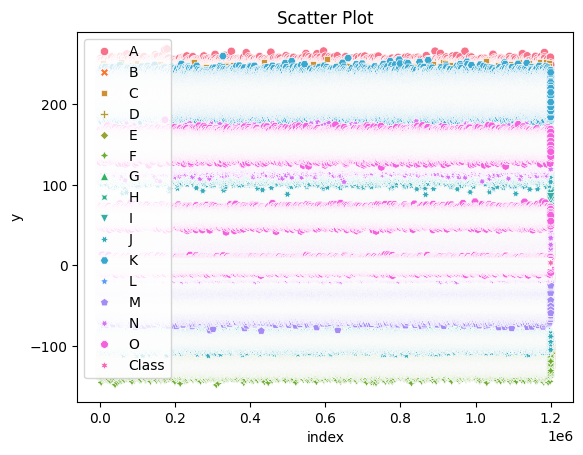

In [55]:
#Scatter plot
sns.scatterplot(data=df)
plt.title('Scatter Plot')
plt.xlabel("index")
plt.ylabel("y")
plt.show()

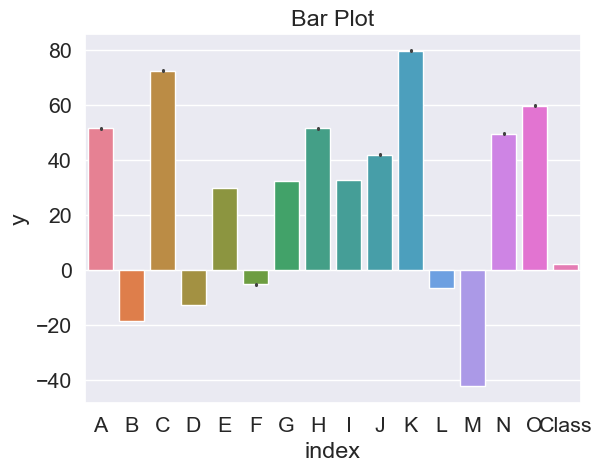

In [101]:
#bar plot
sns.barplot(data=df)
plt.title('Bar Plot')
plt.xlabel("index")
plt.ylabel("y")
plt.show()

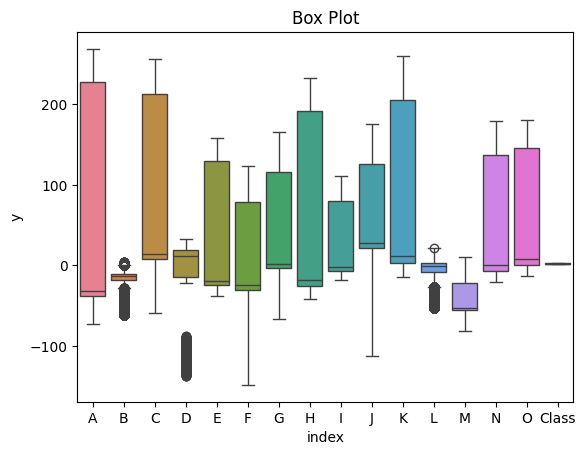

In [58]:
#box plot
sns.boxplot(data=df)
plt.title('Box Plot')
plt.xlabel("index")
plt.ylabel("y")
plt.show()


<Axes: >

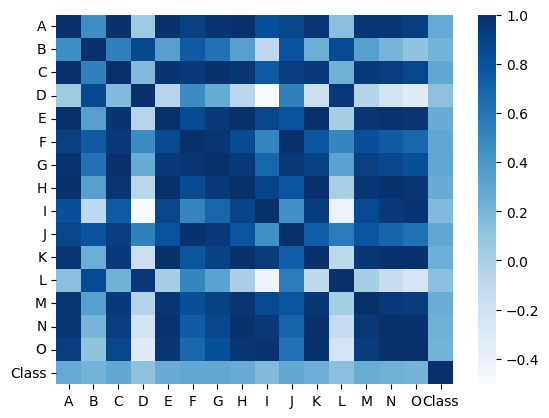

In [60]:
#heatmap
sns.heatmap(df.corr(), cmap="Blues", xticklabels=True, yticklabels=True)



The correlation plot reveals that several features, including A, C, E, and M, exhibit strong intercorrelations with other features. However, these features show only weak correlations with the labels.

**Therefore, it is good to do a PCA to reduce the dimensionality of the data.**

## Train / Test Split

In [141]:
#spliting input and output dataset

X = pd.DataFrame(df.iloc[:,0:len(df.columns)-2])
Y = pd.DataFrame(data=df['Class'])
X.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622


In [142]:
class_counts = Y.value_counts()
class_percentages = (class_counts / len(Y)) * 100
class_percentages

Class
3        47.447988
2        37.692448
1        14.859564
Name: count, dtype: float64

In [143]:
X.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622


In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
print(len(X_train),len(X_test),len(y_train),len(y_test))

835497 358071 835497 358071


In [145]:
X.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622


In [146]:
Y.head()

,Class
0,3
1,2
2,2
3,3
4,3


In [147]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest

In [148]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
df_train_scaled = pd.concat([X_train_scaled.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
df_train_scaled.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Class
835492,-0.698203,-0.147457,-0.577971,0.719145,-0.784024,-0.245084,-0.418484,-0.797212,-1.001459,-0.282762,-0.805202,0.330713,-0.809954,-0.804966,2
835493,-0.651969,-0.148085,-0.539809,0.699896,-0.742569,-0.282888,-0.540472,-0.796302,-0.927786,-0.181844,-0.783382,0.583202,-0.892062,-0.853347,2
835494,-0.714371,0.658963,-0.569915,0.691249,-0.787471,-0.299214,-0.531133,-0.736128,-0.919122,-0.213451,-0.806951,0.788009,-0.662943,-0.818665,2
835495,1.482548,0.469073,1.418030,0.019982,1.437775,1.329739,1.104344,1.556984,1.091705,0.998626,1.477565,-0.104490,1.477535,1.377078,3
835496,-0.864964,-1.933387,-1.075680,-2.440321,-0.585366,-1.568557,-1.264406,-0.593635,0.267095,-1.815773,-0.303478,-1.709265,-0.631232,-0.236226,1


In [149]:
pca = PCA()
df_pca = pca.fit_transform(df_train_scaled.drop('Class',axis=1))
exp_percetange = pca.explained_variance_ratio_*100

#Checking varience in each coloumn
ratios= zip(X_train.columns, exp_percetange)
for column, ratio in ratios:
    print(f'{column}:  {ratio:.2f}%')

A:  72.79%
B:  25.42%
C:  0.64%
D:  0.43%
E:  0.36%
F:  0.07%
G:  0.06%
H:  0.05%
I:  0.05%
J:  0.04%
K:  0.03%
L:  0.02%
M:  0.02%
N:  0.01%


As we can see the 1st two features A and B explain almost > 95% of the variance, hence **reducing the dimensionality to 2** will make the model more simpler

In [150]:
df_pca = pd.DataFrame(df_pca)

In [151]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,4.546000,-0.307993,-0.195631,-0.086309,-0.025406,0.132135,-0.107412,-0.122947,-0.009714,-0.092267,0.007053,-0.006317,-0.061577,-0.012074
1,-1.824395,1.735569,0.345501,0.079307,0.284136,-0.060953,-0.079183,-0.124873,0.021970,0.052028,-0.093974,0.029094,-0.034663,-0.007489
2,-1.936995,1.372970,0.076367,0.080724,-0.086564,0.002842,-0.041850,-0.053436,-0.030284,-0.004579,-0.022013,0.029250,-0.018483,0.014966
3,-3.136554,-4.024580,-0.034236,0.376297,-0.379892,0.069315,0.126436,-0.121961,-0.009444,0.111611,-0.046989,-0.023882,-0.032692,0.003554
4,4.635713,-0.324287,-0.268707,0.203233,-0.205232,-0.082801,-0.041034,0.008245,-0.100545,-0.110627,-0.104034,-0.101246,-0.056697,0.042255


In [152]:
selector = SelectKBest(k=2)
X_new = selector.fit_transform(df_pca, y_train)
X_new.shape

(835497, 2)

In [153]:
X_new = pd.DataFrame(X_new)

In [154]:
X_new.head()

,0,1
0,4.546000,-0.307993
1,-1.824395,1.735569
2,-1.936995,1.372970
3,-3.136554,-4.024580
4,4.635713,-0.324287


In [155]:
X_new[0]

0         4.546000
1        -1.824395
2        -1.936995
3        -3.136554
4         4.635713
            ...   
835492   -2.111009
835493   -2.091976
835494   -1.913647
835495    4.464394
835496   -3.103638
Name: 0, Length: 835497, dtype: float64

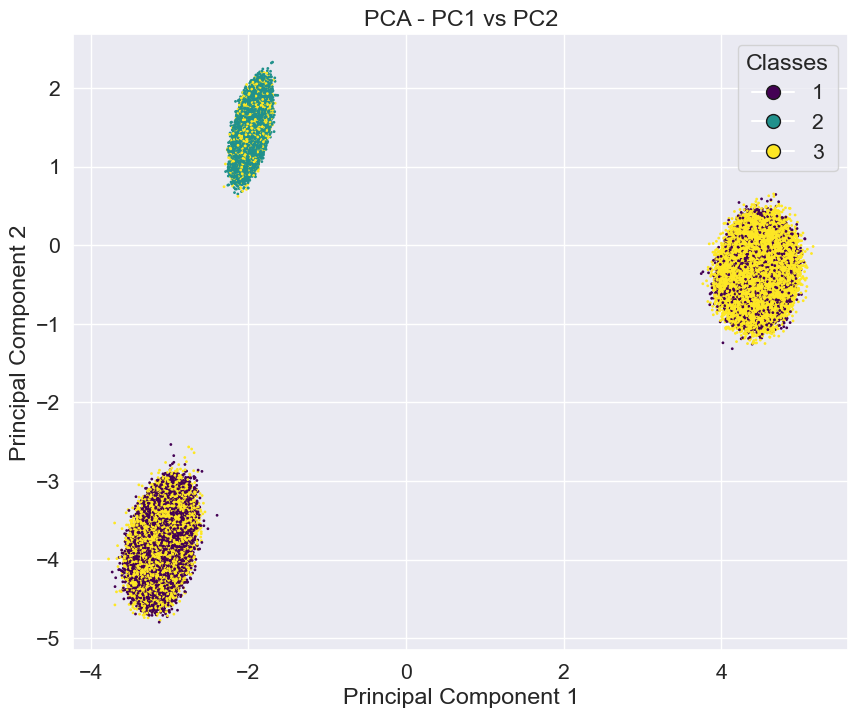

In [156]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

plt.figure(figsize=(10, 8))

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

# Create a color map from the encoded labels
cmap = plt.get_cmap('viridis', np.unique(y_encoded).size)

scatter = plt.scatter(X_new[0], X_new[1], c=y_encoded, cmap=cmap, s=1)

# Adding legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, markeredgecolor='k') for i in range(np.unique(y_encoded).size)]
legend_labels = le.inverse_transform(np.unique(y_encoded))
plt.legend(handles, legend_labels, title="Classes")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - PC1 vs PC2')
plt.show()

## MODEL TRAINING 

In [157]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline

## Pipeline details

In [242]:
# Pipeline-1 : Decision Tree Classifier
pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('selector', SelectPercentile(percentile=90)),
    ('classifier', DecisionTreeClassifier())
])

In [243]:
%%time
pipeline1.fit(X_train, y_train)

CPU times: user 47.6 s, sys: 202 ms, total: 47.8 s
Wall time: 47.9 s


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('selector', SelectPercentile(percentile=90)),
                ('classifier', DecisionTreeClassifier())])

In [244]:
print(classification_report(pipeline1.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.37      0.36      0.37     55402
           2       0.73      0.75      0.74    131844
           3       0.60      0.59      0.60    170825

    accuracy                           0.61    358071
   macro avg       0.57      0.57      0.57    358071
weighted avg       0.61      0.61      0.61    358071



In [194]:
#Pipeline-2 :Random Forest Classifier
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('selector', SelectPercentile(percentile=90)),
    ('classifier', RandomForestClassifier())
])

In [195]:
%%time
pipeline2.fit(X_train, y_train)

CPU times: user 10min 32s, sys: 1.97 s, total: 10min 34s
Wall time: 10min 35s


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('selector', SelectPercentile(percentile=90)),
                ('classifier', RandomForestClassifier())])

In [196]:
print(classification_report(pipeline2.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.30      0.51      0.38     31681
           2       1.00      0.75      0.86    179949
           3       0.64      0.75      0.69    146441

    accuracy                           0.73    358071
   macro avg       0.65      0.67      0.64    358071
weighted avg       0.79      0.73      0.75    358071



In [197]:
#Pipeline-3 :Random Forest Classifier with n estimators
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('selector', SelectPercentile(percentile=90)),
    ('classifier', RandomForestClassifier(n_estimators=20))
])

In [198]:
%%time
pipeline3.fit(X_train, y_train)

CPU times: user 2min, sys: 428 ms, total: 2min
Wall time: 2min


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('selector', SelectPercentile(percentile=90)),
                ('classifier', RandomForestClassifier(n_estimators=20))])

In [199]:
print(classification_report(pipeline3.predict(X_test), y_test))


              precision    recall  f1-score   support

           1       0.33      0.49      0.39     35299
           2       0.99      0.75      0.85    178216
           3       0.63      0.74      0.68    144556

    accuracy                           0.72    358071
   macro avg       0.65      0.66      0.64    358071
weighted avg       0.78      0.72      0.74    358071



In [62]:
#Pipeline -4: KNN Classifier
from sklearn.feature_selection import SelectPercentile
from sklearn.neighbors import KNeighborsClassifier

pipeline4 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('selector', SelectPercentile(percentile=90)),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
])

In [63]:
%%time
pipeline4.fit(X_train, y_train)

CPU times: user 550 ms, sys: 44.2 ms, total: 595 ms
Wall time: 598 ms


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('selector', SelectPercentile(percentile=90)),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [64]:
print(classification_report(pipeline4.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.32      0.41      0.36     41663
           2       0.84      0.75      0.79    151366
           3       0.63      0.65      0.64    165042

    accuracy                           0.67    358071
   macro avg       0.60      0.60      0.60    358071
weighted avg       0.68      0.67      0.67    358071



In [65]:
#Pipeline -5: Naive bayes classifier
from sklearn.naive_bayes import GaussianNB

pipeline5 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('selector', SelectPercentile(percentile=90)),
    ('classifier', GaussianNB())
])

In [66]:
%%time
pipeline5.fit(X_train, y_train)

CPU times: user 177 ms, sys: 41.4 ms, total: 218 ms
Wall time: 218 ms


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('selector', SelectPercentile(percentile=90)),
                ('classifier', GaussianNB())])

In [67]:
print(classification_report(pipeline5.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.55      0.50      0.52     57954
           2       1.00      0.75      0.86    179428
           3       0.57      0.80      0.66    120689

    accuracy                           0.73    358071
   macro avg       0.70      0.68      0.68    358071
weighted avg       0.78      0.73      0.74    358071



In [68]:
#Pipeline6: logisticRegression with Cross Validation

from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=39)

# Define the pipeline
pipeline_6 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('selector', SelectPercentile(percentile=60)),
    ('regressor', LogisticRegression())
])

# Define the k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=39)

# Perform cross-validation on the training set
scores = cross_val_score(pipeline_6, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-validation scores (negative MSE):", scores)
print("Mean cross-validation score (negative MSE):", scores.mean())

# Fit the pipeline on the entire training set and evaluate on the test set
pipeline_6.fit(X_train, y_train)
print(classification_report(pipeline_6.predict(X_test), y_test))
test_score = pipeline_6.score(X_test, y_test)
print("Test set score (R^2):", test_score)

Cross-validation scores (negative MSE): [-0.72028531 -0.71544111 -0.71353646 -0.72402603 -0.72223308]
Mean cross-validation score (negative MSE): -0.719104398262568
              precision    recall  f1-score   support

           1       0.28      0.50      0.36     24755
           2       1.00      0.75      0.86    150048
           3       0.65      0.74      0.69    123589

    accuracy                           0.73    298392
   macro avg       0.64      0.67      0.64    298392
weighted avg       0.79      0.73      0.75    298392

Test set score (R^2): 0.7266481675111933


## Step 4: Model Validation

When evaluating machine learning models on classifiers, relying solely on overall accuracy can be misleading. Accuracy measures the proportion of correct predictions over all predictions, but it doesn't provide insight into how the model performs on individual classes.

Class Imbalance:

Imbalanced Data: If your dataset has classes that are not equally represented, a model could achieve high accuracy by simply predicting the majority class every time.
Impact on Accuracy: The model with 73% accuracy might be predicting the majority class more often, thus inflating its accuracy without actually performing better on minority classes.

### Thus we decide to choose model which performed better in confusion matrix, thus reducing wrong classification on lower class datasets.


### CROSS VALIDATION

In [272]:
# Define the stratified k-fold cross-validator
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5)

# Perform cross-validation on the training set
scores = cross_val_score(pipeline1, X_train, y_train, cv=stratified_kfold)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

# Fit the pipeline on the entire training set and evaluate on the test set
pipeline1.fit(X_train, y_train)
test_score = pipeline5.score(X_test, y_test)
print("Test set score:", test_score)

Cross-validation scores: [0.6147696  0.61548175 0.6133789  0.61567095 0.61496478]
Mean cross-validation score: 0.6148531945118205
Test set score: 0.7257136154561525


## Confusion Matrix

In [273]:
y_pred = pipeline5.predict(X_test)

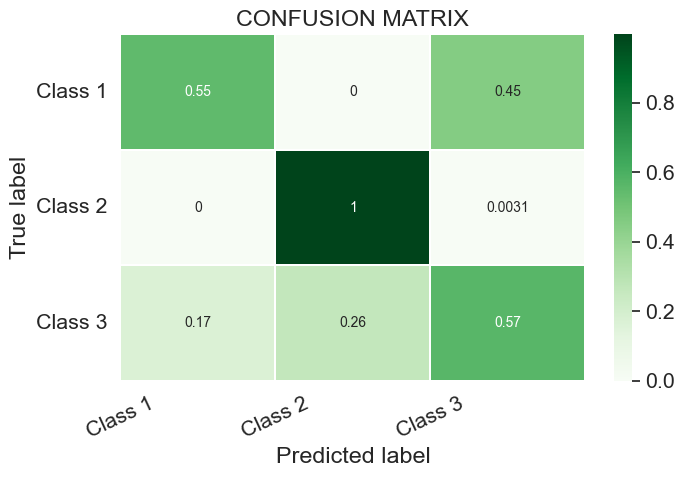

In [274]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(7.5,4.5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Class 1', 'Class 2', 'Class 3']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CONFUSION MATRIX')
plt.show()

## Classfication Report

In [275]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.55      0.50      0.52     57954
           2       1.00      0.75      0.86    179428
           3       0.57      0.80      0.66    120689

    accuracy                           0.73    358071
   macro avg       0.70      0.68      0.68    358071
weighted avg       0.78      0.73      0.74    358071



In [162]:
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

In [276]:
%%time
input_types = dict([(x, FloatTensorType([None, 1])) for x in X_train.columns.values])

try:
    model_onnx = convert_sklearn(pipeline5,
                                 'pipeline_onnx',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

CPU times: user 25.7 ms, sys: 28.1 ms, total: 53.8 ms
Wall time: 57.6 ms


In [277]:
import onnxruntime as rt

inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("pipeline.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)

print(classification_report(predict_onnx[0], y_test))

              precision    recall  f1-score   support

           1       0.55      0.50      0.52     57954
           2       1.00      0.75      0.86    179428
           3       0.57      0.80      0.66    120689

    accuracy                           0.73    358071
   macro avg       0.70      0.68      0.68    358071
weighted avg       0.78      0.73      0.74    358071



In [278]:
import pydot
import graphviz


In [279]:
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from IPython.display import display

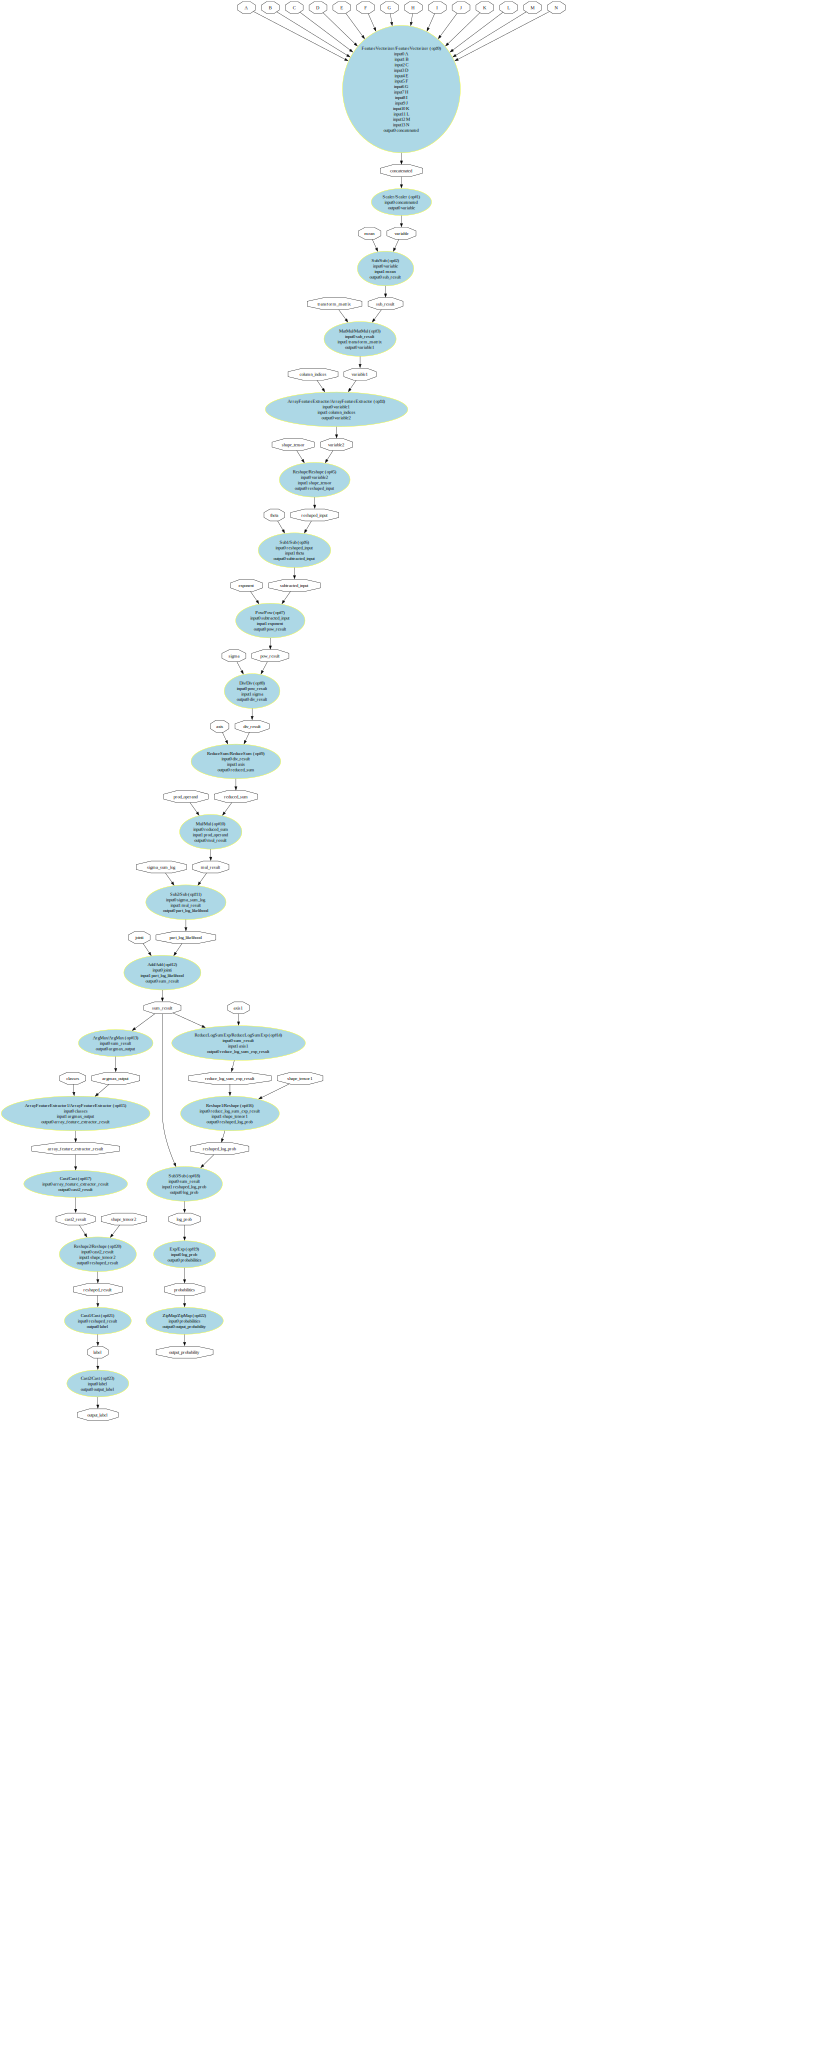

In [286]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="lightblue",
                                                            style="filled"))

# Convert the Pydot graph to a string and modify the size attribute
dot_string = pydot_graph.to_string()
dot_string = dot_string.replace('rankdir=TB;', 'rankdir=TB; size="30,60"; dpi="50";')

# Create a Graphviz Source object from the modified string
source = graphviz.Source(dot_string)

# Display the graph directly in the Jupyter notebook cell
display(source)